# Keyword-Based News Classification

I want to build a simple keyword-based news classification model using the short_description field of news articles, so that I can evaluate how well frequent words alone can classify articles into four categories.

In [41]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords



In [42]:

df = pd.read_json("data/News_Category_Dataset_v3.json", lines=True)
df

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22
...,...,...,...,...,...,...
209522,https://www.huffingtonpost.com/entry/rim-ceo-t...,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,TECH,Verizon Wireless and AT&T are already promotin...,"Reuters, Reuters",2012-01-28
209523,https://www.huffingtonpost.com/entry/maria-sha...,Maria Sharapova Stunned By Victoria Azarenka I...,SPORTS,"Afterward, Azarenka, more effusive with the pr...",,2012-01-28
209524,https://www.huffingtonpost.com/entry/super-bow...,"Giants Over Patriots, Jets Over Colts Among M...",SPORTS,"Leading up to Super Bowl XLVI, the most talked...",,2012-01-28
209525,https://www.huffingtonpost.com/entry/aldon-smi...,Aldon Smith Arrested: 49ers Linebacker Busted ...,SPORTS,CORRECTION: An earlier version of this story i...,,2012-01-28


#### Preparation
Use the Kaggle News Category Dataset.
Keep only the categories: POLITICS, TRAVEL, SPORTS, HOME & LIVING.
Select 1000 samples per category (total 4000).
Retain only the short_description column and corresponding label.
Perform an 80/20 stratified split into train and test sets.

In [43]:
categories = ["POLITICS", "TRAVEL", "SPORTS", "HOME & LIVING"]
df = df[df["category"].isin(categories)]

In [44]:
df = df[["short_description", "category"]]

In [45]:
df = df.groupby("category").apply(lambda x: x.sample(1000, random_state=42)).reset_index(drop=True)


C:\Users\bbuser\AppData\Local\Temp\ipykernel_18272\4284082523.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("category").apply(lambda x: x.sample(1000, random_state=42)).reset_index(drop=True)


In [46]:
df

,short_description,category
0,"For many people, the most hectic shopping day ...",HOME & LIVING
1,"The comedy special ""Aziz Ansari: Right Now"" de...",HOME & LIVING
2,"Yep, it really can.",HOME & LIVING
3,"You've got to be kidding us, it's a horse-shap...",HOME & LIVING
4,Life is expensive! Use your talents to help de...,HOME & LIVING
...,...,...
3995,"Leshan Giant Buddha, China An old Chinese monk...",TRAVEL
3996,If you're one of the many families getting rea...,TRAVEL
3997,,TRAVEL
3998,Groups like Girls LOVE Travel and the Solo Fem...,TRAVEL


In [47]:
train_df, test_df = train_test_split(
    df, 
    test_size=0.2, 
    stratify=df["category"], 
    random_state=42
)

In [48]:
try:
    stop_words = set(stopwords.words("english"))
except LookupError:
    nltk.download("stopwords")
    stop_words = set(stopwords.words("english"))

def preprocess_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"[^\w\s]", " ", text)   # remove punctuation
    text = re.sub(r"\d+", " ", text)       # remove numbers
    tokens = [w for w in text.split() if w not in stop_words]
    return " ".join(tokens)

train_df["processed_text"] = train_df["short_description"].apply(preprocess_text)
test_df["processed_text"]  = test_df["short_description"].apply(preprocess_text)

#### Word Frequency & Word Cloud
Generate word clouds from the short_description texts in the training set for each category.
Extract the most frequent words per category.
Save these into category-specific sets.

In [54]:

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

#  extra words i DID FIND
stop_words.update(["u", "im", "us"])


def clean_text(text):
    if not isinstance(text, str):
        return []

    text = text.lower()

    text = re.sub(r'[^a-z\s]', ' ', text)

    words = text.split()

    words = [w for w in words if w not in stop_words]
    return words

category_word_sets = {}

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bbuser\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


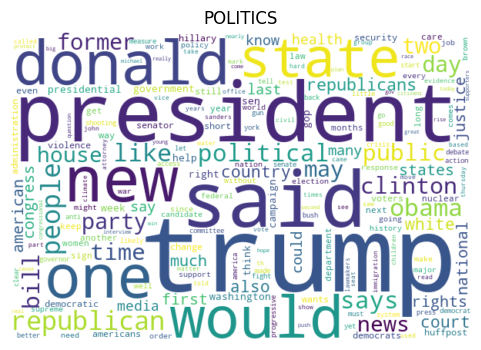

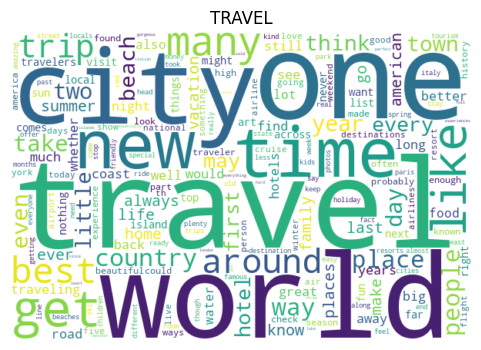

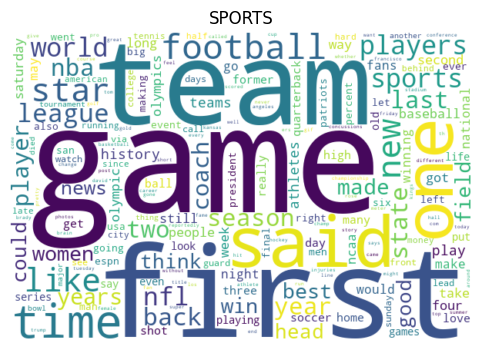

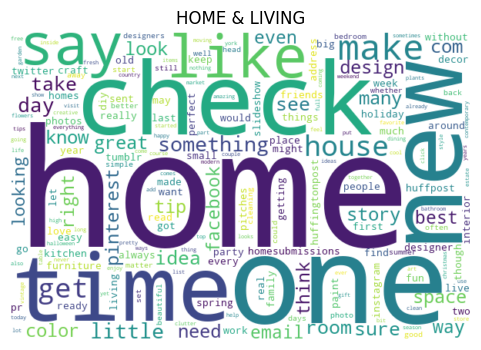

In [55]:
for cat in categories:
   
    all_words = []
    for desc in train_df[train_df["category"] == cat]["short_description"]:
        all_words.extend(clean_text(desc))

   
    word_counts = Counter(all_words)


    category_word_sets[cat] = [w for w, c in word_counts.most_common(50)]

    wc = WordCloud(width=600, height=400, background_color="white").generate_from_frequencies(word_counts)

    plt.figure(figsize=(6,4))
    plt.imshow(wc, interpolation="bilinear")
    plt.title(cat)
    plt.axis("off")
    plt.show()


### practice

In [58]:

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_df["processed_text"])
bow_df = pd.DataFrame(X_train.toarray(), columns=vectorizer.get_feature_names_out())
print("--- Bag of Words (train) shape ---")
print(bow_df.shape)




--- Bag of Words (train) shape ---
(3200, 9889)


In [59]:
def top_n_keywords_per_category(n):
    kw = {}
    for cat in categories:
        tokens = " ".join(train_df[train_df["category"] == cat]["processed_text"]).split()
        freq = Counter(tokens).most_common(n)
        kw[cat] = {w for w, _ in freq}
    return kw

In [60]:

category_keywords_10 = top_n_keywords_per_category(10)
print("\n--- Top 10 keyword sets per category ---")
for c, words in category_keywords_10.items():
    print(f"{c}: {sorted(list(words))}")




--- Top 10 keyword sets per category ---
POLITICS: ['donald', 'new', 'one', 'president', 'republican', 'said', 'state', 'trump', 'u', 'would']
TRAVEL: ['best', 'city', 'get', 'like', 'many', 'new', 'one', 'time', 'travel', 'world']
SPORTS: ['first', 'football', 'game', 'like', 'new', 'one', 'said', 'star', 'team', 'time']
HOME & LIVING: ['check', 'home', 'house', 'like', 'make', 'new', 'one', 'say', 'time', 'us']


In [61]:

def classify_keywords(text, keyword_dicts):
    words = set(text.split())
    scores = {cat: len(words & kws) for cat, kws in keyword_dicts.items()}
    return max(scores.items(), key=lambda x: (x[1], -categories.index(x[0])))[0]


In [62]:
def evaluate_top_ns(n_list):
    results = []
    for n in n_list:
        kwd = top_n_keywords_per_category(n)
        preds = test_df["processed_text"].apply(lambda t: classify_keywords(t, kwd))
        acc = (preds == test_df["category"]).mean()
        results.append({"top_n": n, "accuracy": acc})
        print(f"Top {n} words accuracy: {acc:.4f}")
    return pd.DataFrame(results)

sizes = [10, 20, 30, 50]
results_df = evaluate_top_ns(sizes)

Top 10 words accuracy: 0.3825
Top 20 words accuracy: 0.4275
Top 30 words accuracy: 0.4512
Top 50 words accuracy: 0.4713


In [63]:

print("\n--- Sample Predictions (Top 30 dictionary) ---")
kwd_30 = top_n_keywords_per_category(30)
sample = test_df.head(8).copy()
sample["pred"] = sample["processed_text"].apply(lambda t: classify_keywords(t, kwd_30))
for _, r in sample.iterrows():
    print(f"PRED={r['pred']:<13} TRUE={r['category']:<13} TEXT={r['short_description']}")




--- Sample Predictions (Top 30 dictionary) ---
PRED=SPORTS        TRUE=HOME & LIVING TEXT=Here's what experts have to say about potential shortages during the 2021 holiday season.
PRED=POLITICS      TRUE=POLITICS      TEXT=State Rep. Todd Courser (R) planned to hide his affair with fellow Rep. Cindy Gamrat (R) by implicating himself in a fake sex scandal to detract attention from the affair.
PRED=POLITICS      TRUE=HOME & LIVING TEXT=And it only took her 1,000 hours to complete it.
PRED=HOME & LIVING TRUE=POLITICS      TEXT="Ladies, look at this face, and look at all of your faces -- the face of leadership."
PRED=HOME & LIVING TRUE=HOME & LIVING TEXT=There's nothing like spending the holidays with your mom, dad and your perennially tipsy uncle Eddie, but you don't need
PRED=TRAVEL        TRUE=TRAVEL        TEXT=The new results matched up nicely with small surveys taken by travel editors at New York bars, during which they were told
PRED=POLITICS      TRUE=SPORTS        TEXT=This week 

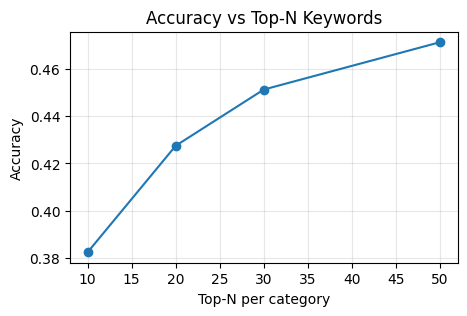

In [64]:

plt.figure(figsize=(5,3))
plt.plot(results_df.top_n, results_df.accuracy, marker="o")
plt.title("Accuracy vs Top-N Keywords")
plt.xlabel("Top-N per category")
plt.ylabel("Accuracy")
plt.grid(alpha=0.3)